In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

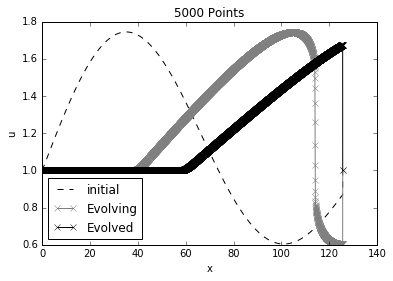

In [2]:
# Let's evolve burgers' equation in time

nx = 5000 # number of x points
nt = 60000 # number of time steps
x = np.linspace(0, 40 * np.pi, nx)

# initially purturb u
u = 1 + .5 * np.sin(x/20) + 0.3 * np.sin(x/35)
u[-1] = 1

u0 = u.copy()
dx = x[1] - x[0]
dt = .001

# The viscosity is non-uniform
# nu = np.ones(x.size) * 1e-6 + 1e-4 * np.sin(x / 10) + 1e-6 * np.sin(x / 20) + 1e-6 * np.sin(x / 30)
nu = 1e-6
# u_record holds all the snapshots. 
# The rows represent spatial points and the columns are different times.
u_record = np.zeros((nx, nt/200))

# Evolve through time
ii = 0
for _ in range(nt):
    un = u.copy()
    u[1:-1] = un[1:-1] + dt *( -1 * un[1:-1] * (un[1:-1] - un[:-2]) / dx + nu * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2 )
#    u[1:-1] = un[1:-1] + dt *( -1 * un[1:-1] * (un[1:-1] - un[:-2]) / dx + nu[1:-1] * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2 )

    # Save every 200th time step
    if _ % (200) == 0:
        u_record[:, ii] = u
        ii += 1
    
plt.plot(x, u0, ls='--', c='k', label="initial")
plt.plot(x, u_record[:, -100], c='grey', label="Evolving", marker='x')
plt.plot(x, u_record[:, -1], c='k', label="Evolved", marker='x')
#plt.plot(x, u, c='k', label="Evolved", marker='x')
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.legend(loc="lower left")
ax.set_title("%i Points"%nx)
ax.set_ylabel("u")
ax.set_xlabel('x')


In [3]:
# SVD the covariance matrix
# P, D, Q = np.linalg.svd(u_record) # P D Q is the approximation
psi, D, phi = np.linalg.svd(u_record) # P D Q is the approximation


S = np.zeros((nx, 300))
mm = min(nx, 300)
S[:mm, :mm] = np.diag(D)

assert(np.allclose(u_record, np.dot(psi, np.dot(S, phi)))) # check that a = P D Q
#P.shape, Q.shape, S.shape
phi = phi.T

from scipy.integrate import simps
for ss in range(phi.shape[1]):
    phi[:, ss] /= np.dot(phi[:, ss], phi[:, ss])
    
for ss in range(psi.shape[1]):
    psi[:, ss] /= np.dot(psi[:, ss], psi[:, ss])

In [4]:
a = phi[:, 3]
b = phi[:, 4]
np.dot(a, b)

1.3964523981613297e-16

(0, 100)

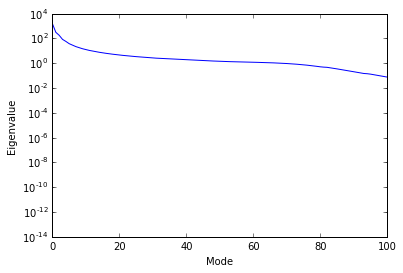

In [5]:
# plot eigenvalues
plt.plot(D)
plt.yscale('log')
plt.xlabel("Mode")
plt.ylabel("Eigenvalue")
plt.xlim(0, 100)

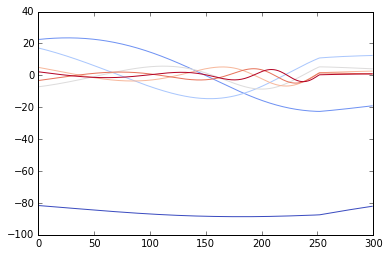

In [6]:
# The columns of phi are the basis functions, right?
MODES=7

# Calculate the weight functions
Q = np.dot(S[:, :MODES], phi[:, :MODES].T)

# normalize phi - makes my solution worse!
#for i in range(len(phi[1, :])):
#    phi[:, i] = phi[:, i] / np.sum(phi[:, i])

# Plot the dominant coefficients against time!
colors = plt.cm.coolwarm(np.arange(MODES) / (MODES-1.))
for i in range(MODES): plt.plot(Q[i, :], c=colors[i])
    
# TODO Check if orthogonal

((5000, 300), (300, 300), (5000, 5000))

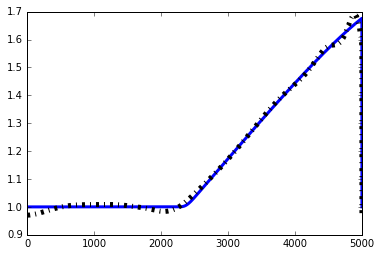

In [7]:
# plot the snapshot at last time 
plt.plot(u_record[:, -1], linewidth=3)

# reconstruct the snapshot using phi
ubar = np.dot(psi, Q)
plt.plot(ubar[:, -1], c='k', ls='-.', linewidth=5)
Q.shape, phi.shape, psi.shape
#plt.ylim(0,2)

/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


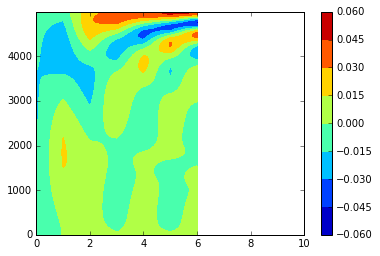

In [8]:
plt.contourf(psi[:, :MODES])
plt.xlim(0,10)
plt.colorbar()

In [9]:

ubar_red = np.dot(Q[:, :MODES], psi[0, :MODES].T)
print ubar_red.shape

#plt.plot(x, u_record[:, 0], ls='--', c='silver', label="True Initial")
#plt.plot(x, u_record[:, -200], c='grey', label="True Evolving", ls='--')
#plt.plot(x, u_record[:, -1], c='dimgrey', label="True Evolved", ls='--')

#plt.plot(x,ubar_red[:, 0], c='plum', label="Reduced Initial")
#plt.plot(x,ubar_red[:, -200], c='orchid', label="Reduced Evolving")
#plt.plot(x,ubar_red[:, -1], c='darkorchid', label="Reduced Evolved")
#plt.legend(bbox_to_anchor=[.95, 1.4], ncol=2)

(5000,)


In [ ]:
import numba as nb
from scipy.integrate import simps

@nb.jit
def genterms(MODES):
    TERM1 = np.zeros((MODES, MODES))
    TERM2 = np.zeros((MODES, MODES, MODES))
    for ii in range(MODES):
        for kk in range(MODES):
            #print simps(psi[:, kk] *  np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx)
            TERM1[ii, kk] = simps(psi[:, kk] *  np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx)
            for jj in range(MODES):
                TERM2[ii, jj, kk] = simps(psi[:, kk] * psi[:, ii] * np.gradient(psi[:, jj], dx))
    return TERM1, TERM2
TERM1, TERM2 = genterms(MODES)

In [ ]:
from scipy.integrate import simps
import numba as nb
@nb.jit
def dqdt(a, kk):
    # calculate first term
    # print a.shape, psi[:,0].shape
    #print a.shape, psi.shape, np.gradient(psi[:a.size, :a.size] ** 2, dx, axis=0).shape
    #print simps(psi[ii, :a.size].T **2, x, dx).shape
    #print psi[:, ii].shape
    #n = nu * a * np.gradient(psi[:, ii] ** 2, dx) - .5 * a **2 * psi[:, ii] ** 3
    #return n / simps(psi[:, ii] **2, x, dx)
    t1 = 0
    for ii in range(a.shape[0]):
        t1 += nu * a[ii] * TERM1[ii, kk]
    t2 = 0
    for ii in range(a.shape[0]):
        for jj in range(a.shape[0]):
            t2 += a[jj] * a[ii] * TERM2[ii, jj, kk]
    return t1 - t2
#    return nu * a * np.sum(simps(phi[ii], np.gradient(np.gradient(phi, dx), dx), dx), axis=1) -  np.sum(np.sum(a))
dqdt(Q[:, 0], 0)



In [ ]:
#from scipy.integrate import simps
#import numba as nb
#@nb.jit
#def dqdt(a, kk):
#    # calculate first term
#    # print a.shape, psi[:,0].shape
#    #print a.shape, psi.shape, np.gradient(psi[:a.size, :a.size] ** 2, dx, axis=0).shape
#    #print simps(psi[ii, :a.size].T **2, x, dx).shape
#    #print psi[:, ii].shape
#    #n = nu * a * np.gradient(psi[:, ii] ** 2, dx) - .5 * a **2 * psi[:, ii] ** 3
#    #return n / simps(psi[:, ii] **2, x, dx)
#    t1 = 0
#    for ii in range(a.shape[0]):
#        t1 += nu * a[ii] * simps(psi[:, kk] *  np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx)
#    t2 = 0
#    for ii in range(a.shape[0]):
#        for jj in range(a.shape[0]):
#            t2 += a[jj] * a[ii] * simps(psi[:, kk] * psi[:, ii] * np.gradient(psi[:, jj], dx))
#    return t1 - t2
#    return nu * a * np.sum(simps(phi[ii], np.gradient(np.gradient(phi, dx), dx), dx), axis=1) -  np.sum(np.sum(a))
#dqdt(Q[:, 0], 0)



In [ ]:
#MODES = 5

#ubar = np.dot( c.T, Q[:, :MODES].T)
#ubar = np.dot(a, phi[:, :MODES].T)

# Record initial time
#plt.plot(x, u_record[:, 0], c='dimgrey', label="True Initial", ls='--')
#plt.plot(x,ubar, c='plum', label="Reduced Initial")
Q = np.dot(S[:, :MODES], phi[:, :MODES].T)

# Evolve it
a = Q[:MODES, 0].copy()

@nb.jit
def evolve(a):
    n_records = 0
    u_red_record = np.zeros((nx, nt/200))
    for _ in range(nt):
        #na = a.copy()
        #del a
        for ii in range(MODES):
            na = a.copy()
            a[ii] = na[ii] + dqdt(na, ii) * dt
            #del na
        if _ % (200) == 0:
            u_red_record[:, n_records] = np.dot(a, psi[:, :MODES].T).copy()
            n_records += 1
    #print a[0], dqdt(na)[0] * dt
    return a, u_red_record
a, u_red_record_g6 = evolve(a)
ubar = np.dot(Q[:MODES, 0], psi[:, :MODES].T)
ubarf = np.dot(a, psi[:, :MODES].T)
print ubarf.shape
plt.plot(x,ubarf, c='red', label="Reduced Evolved")
plt.plot(x,ubar, c='grey', label="Reduced Initial", ls='--')
    
    
plt.legend(bbox_to_anchor=[.95, 1.4], ncol=2)

In [12]:
from scipy.integrate import simps
import numba as nb



def lspg(a, a_guess):
        
    t1 = 0
    for ii in range(a.shape[0]):
        t1 += ((a_guess[ii] - a[ii]) / dt ) ** 2
    t2 = 0
    for ii in range(a.shape[0]):
        for jj in range(a.shape[0]):
            for ll in range(a.shape[0]):
                t2 += a[ii] * a[jj] * a[ll] ** 2 * simps(np.gradient(phi[:, jj], dx) * np.gradient(phi[:, ll], dx), dx=dx)
    t3 = 0
    for ii in range(a.shape[0]):
        for jj in range(a.shape[0]):
            t3 += nu ** 2 * a[ii] * a[jj] * simps(np.gradient(np.gradient(phi[:, ii], dx), dx), np.gradient(np.gradient(phi[:, jj], dx), dx), dx=dx)
    print t1 + t2 - t3        
    return t1 + t2 - t3




In [ ]:
MODES = 20

from scipy.optimize import least_squares
#ubar = np.dot( c.T, Q[:, :MODES].T)
#ubar = np.dot(a, phi[:, :MODES].T)

# Record initial time
#plt.plot(x, u_record[:, 0], c='dimgrey', label="True Initial", ls='--')
#plt.plot(x,ubar, c='plum', label="Reduced Initial")
Q = np.dot(S, phi.T)

# Evolve it
a = Q[:MODES, 0].copy()

#@nb.jit
#def evolve(a):
n_records = 0
#u_red_record_lspg6 = np.zeros((nx, nt/200))
a_record = np.zeros((nx, nt/200))
for _ in range(nt):
    #na = a.copy()
    #del a
    for ii in range(MODES):
        na = a.copy()
        a[ii] = least_squares(lspg, na[ii] + .1).x
        #del na
    if _ % (200) == 0:
        #u_red_record[:, n_records] = np.dot(a, psi[:, :MODES].T).copy()
        a_record[:, n_records] = np.dot(a, psi[:, :MODES].T).copy()
        n_records += 1
#print a[0], dqdt(na)[0] * dt

a, u_red_record_g6 = evolve(a)
ubar = np.dot(Q[:MODES, 0], psi[:, :MODES].T)
ubarf = np.dot(a, psi[:, :MODES].T)
print ubarf.shape
plt.plot(x,ubarf, c='red', label="Reduced Evolved")
plt.plot(x,ubar, c='grey', label="Reduced Initial", ls='--')
    
    
plt.legend(bbox_to_anchor=[.95, 1.4], ncol=2)

(5000, 300)


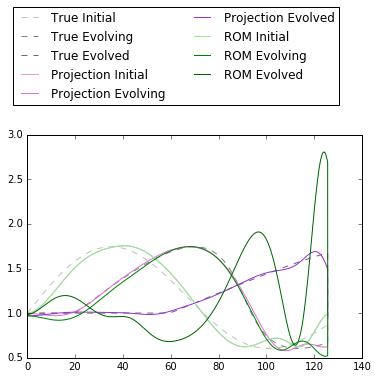

In [19]:
#MODES = 3
ubar_red = np.dot(Q[:MODES, :].T, psi[:, :MODES].T).T
print ubar_red.shape

END = -1

plt.plot(x, u_record[:, 0], ls='--', c='silver', label="True Initial")
plt.plot(x, u_record[:, -200], c='grey', label="True Evolving", ls='--')
plt.plot(x, u_record[:, END], c='dimgrey', label="True Evolved", ls='--')

plt.plot(x,ubar_red[:, 0], c='plum', label="Projection Initial")
plt.plot(x,ubar_red[:, -200], c='orchid', label="Projection Evolving")
plt.plot(x,ubar_red[:, END], c='darkorchid', label="Projection Evolved")

plt.plot(x,u_red_record_g6[:, 0], c='lightgreen', label="ROM Initial")
plt.plot(x,u_red_record_g6[:, -200], c='green', label="ROM Evolving")
plt.plot(x,u_red_record_g6[:, END], c='darkgreen', label="ROM Evolved")

plt.legend(bbox_to_anchor=[.95, 1.6], ncol=2)

In [82]:
import numpy as np
import numba as nb
from scipy.optimize import least_squares, leastsq, lsq_linear
Q = np.dot(S, phi.T)
MODES = 1
a = Q[:MODES, 0].copy()
nt = 100
dt = .1
np.random.seed(3)
@nb.jit
def residual(dadt, current_a):
    t1 = np.sum(dadt ** 2)
    t2, t3 = 0, 0
    for ii in range(current_a.size):
        for jj in range(current_a.size):
                t3 += current_a[ii] * current_a[jj] * (
                    simps(
                        np.gradient(np.gradient(psi[:, ii], dx), dx) *
                        np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx))
                
                for kk in range(current_a.size):
                    for ll in range(current_a.size):
                        t2 += a[ii] * a[jj] * a[kk] * a[ll] * simps(
                        psi[:, ii] * psi[:, jj] * 
                            np.gradient(psi[:, ii], dx) * 
                            np.gradient(psi[:, jj], dx))
   # print(t1+t2-t3, np.sum(dadt)) 
    return (t1 + t2 - t3) - 5 * np.sum(dadt ** 2)

@nb.jit
def evolve(a):
    a_record = np.zeros((nt, MODES))
    for _ in range(nt):
        dadt = least_squares(residual, a, args=(a,)).x
        #dadt = leastsq(residual, np.random.random(a.size), args=(a,))[0]
        #dadt = mini(residual, np.ones(a.size), args=(a,)).x
        #print(dadt)
        a += dadt * dt
        a_record[_, :] = a.copy()
    return a_record

In [83]:
anew = evolve(a)

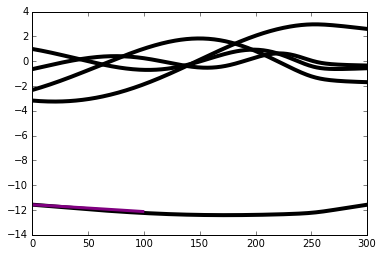

In [84]:


#plt.plot(anew[:, 2], c='orange')
#plt.plot(anew[:, 3], c='teal')
#plt.plot(anew[:, 4], c='brown')

plt.plot(Q.T[:, 0], c='k', lw=4)
plt.plot(Q.T[:, 1], c='k', lw=4)
plt.plot(Q.T[:, 2], c='k', lw=4)
plt.plot(Q.T[:, 3], c='k', lw=4)
plt.plot(Q.T[:, 4], c='k', lw=4)

plt.plot(anew[:, 0], c='purple', lw=3)
#plt.plot(anew[:, 1], c='b', lw=3)


In [24]:
#residual(anew[-1], anew[-2])
MODES

20

(100, 100) (100, 300)


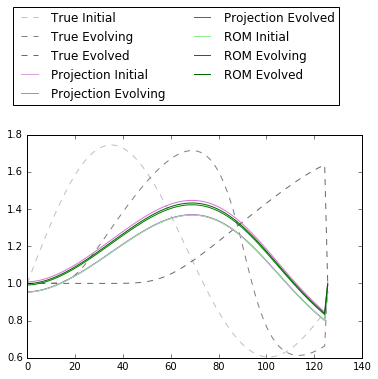

In [85]:

ubar_red = np.dot(Q[:MODES, :].T, psi[:, :MODES].T).T
ubar_lspg = np.dot(anew.T[:MODES, :].T, psi[:, :MODES].T).T
print ubar_lspg.shape, ubar_red.shape

END = -1

plt.plot(x, u_record[:, 0], ls='--', c='silver', label="True Initial")
plt.plot(x, u_record[:, -200], c='grey', label="True Evolving", ls='--')
plt.plot(x, u_record[:, END], c='dimgrey', label="True Evolved", ls='--')

plt.plot(x,ubar_red[:, 0], c='plum', label="Projection Initial")
plt.plot(x,ubar_red[:, -200], c='orchid', label="Projection Evolving")
plt.plot(x,ubar_red[:, END], c='darkorchid', label="Projection Evolved")

plt.plot(x,ubar_lspg[:, 0], c='lightgreen', label="ROM Initial")
plt.plot(x,ubar_lspg[:, -15], c='green', label="ROM Evolving")
plt.plot(x,ubar_lspg[:, END], c='darkgreen', label="ROM Evolved")

plt.legend(bbox_to_anchor=[.95, 1.6], ncol=2)

In [25]:
from scipy.integrate import simps
import numba as nb
@nb.jit
def dqdt(a, kk):
    # calculate first term
    # print a.shape, psi[:,0].shape
    #print a.shape, psi.shape, np.gradient(psi[:a.size, :a.size] ** 2, dx, axis=0).shape
    #print simps(psi[ii, :a.size].T **2, x, dx).shape
    #print psi[:, ii].shape
    #n = nu * a * np.gradient(psi[:, ii] ** 2, dx) - .5 * a **2 * psi[:, ii] ** 3
    #return n / simps(psi[:, ii] **2, x, dx)
    t1 = 0
    for ii in range(a.shape[0]):
        t1 += nu * a[ii] * simps(psi[:, kk] *  np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx)
    t2 = 0
    for ii in range(a.shape[0]):
        for jj in range(a.shape[0]):
            t2 += a[jj] * a[ii] * simps(psi[:, kk] * psi[:, ii] * np.gradient(psi[:, jj], dx))
    return t1 - t2
#    return nu * a * np.sum(simps(phi[ii], np.gradient(np.gradient(phi, dx), dx), dx), axis=1) -  np.sum(np.sum(a))
dqdt(Q[:, 0], 0)


-0.2255512812709956

In [1]:
import numba as nb
from scipy.integrate import simps
MODES = 10
@nb.jit
def genterms(MODES):
    TERM1 = np.zeros((MODES, MODES))
    TERM2 = np.zeros((MODES, MODES, MODES))
    for ii in range(MODES):
        for kk in range(MODES):
            #print simps(psi[:, kk] *  np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx)
            TERM1[ii, kk] = simps(psi[:, kk] *  np.gradient(np.gradient(psi[:, ii], dx), dx), dx=dx)
            for jj in range(MODES):
                TERM2[ii, jj, kk] = simps(psi[:, kk] * psi[:, ii] * np.gradient(psi[:, jj], dx))
    return TERM1, TERM2
TERM1, TERM2 = genterms(MODES)


NameError: global name 'np' is not defined

In [ ]:
@nb.jit
def dqdt(a, kk):
    # calculate first term
    # print a.shape, psi[:,0].shape
    #print a.shape, psi.shape, np.gradient(psi[:a.size, :a.size] ** 2, dx, axis=0).shape
    #print simps(psi[ii, :a.size].T **2, x, dx).shape
    #print psi[:, ii].shape
    #n = nu * a * np.gradient(psi[:, ii] ** 2, dx) - .5 * a **2 * psi[:, ii] ** 3
    #return n / simps(psi[:, ii] **2, x, dx)
    t1 = 0
    for ii in range(a.shape[0]):
        t1 += nu * a[ii] * TERM1[ii, kk]
    t2 = 0
    for ii in range(a.shape[0]):
        for jj in range(a.shape[0]):
            t2 += a[jj] * a[ii] * TERM2[ii,jj,kk]
    return t1 - t2
#    return nu * a * np.sum(simps(phi[ii], np.gradient(np.gradient(phi, dx), dx), dx), axis=1) -  np.sum(np.sum(a))
dqdt(Q[:3, 0], 0)



In [ ]:
MODES = 10

#ubar = np.dot( c.T, Q[:, :MODES].T)
#ubar = np.dot(a, phi[:, :MODES].T)

# Record initial time
#plt.plot(x, u_record[:, 0], c='dimgrey', label="True Initial", ls='--')
#plt.plot(x,ubar, c='plum', label="Reduced Initial")
Q = np.dot(S, phi.T)

# Evolve it
a = Q[:MODES, 0].copy()

@nb.jit
def evolve(a):
    n_records = 0
    u_red_record = np.zeros((nx, nt/200))
    for _ in range(nt):
        #na = a.copy()
        #del a
        for ii in range(MODES):
            na = a.copy()
            a[ii] = na[ii] + dqdt(na, ii) * dt
            #del na
        if _ % (200) == 0:
            u_red_record[:, n_records] = np.dot(a, psi[:, :MODES].T).copy()
            n_records += 1
    #print a[0], dqdt(na)[0] * dt
    return a, u_red_record
a, u_red_record_g6 = evolve(a)
ubar = np.dot(Q[:MODES, 0], psi[:, :MODES].T)
ubarf = np.dot(a, psi[:, :MODES].T)
print ubarf.shape
plt.plot(x,ubarf, c='red', label="Reduced Evolved")
plt.plot(x,ubar, c='grey', label="Reduced Initial", ls='--')
    
    
plt.legend(bbox_to_anchor=[.95, 1.4], ncol=2)